In [40]:
"""
    Reprodicble Figure 4.
"""

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from rich import print as rprint
from scipy.stats import rankdata
from sklearn.utils.fixes import platform
from PIL import Image

from utils import make_experiment_path

# --
# Plot settings (for 8-inch wide paper figures)

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 16,
})

# --
# CLI

# def parse_args():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--outdir',         type=str,   default='results')
    
#     parser.add_argument('--runner',         type=str,   default='qselect', choices=['qselect'])
#     parser.add_argument('--embed_provider', type=str,   default='google')
#     parser.add_argument('--embed_model',    type=str,   default=None)
#     parser.add_argument('--dataset',        type=str,   default='math:subject=algebra')
#     parser.add_argument('--score_col',      type=str,   default='score')
    
#     parser.add_argument('--n_replicates',   type=int,   default=1024)
    
#     # make plots for different n_samples
#     parser.add_argument('--n_samples', type=int, default=8)

#     args = parser.parse_args()

#     exp_path = make_experiment_path(args.embed_provider, args.embed_model, args.dataset, args.score_col, args.n_replicates)
#     args.tsv_path = Path(args.outdir) / exp_path / args.runner / 'results.tsv'
#     args.plot_dir = Path('plots')     / exp_path / args.runner
#     args.plot_dir.mkdir(parents=True, exist_ok=True)
        
#     return args


# args   = parse_args()

embed_provider='google'
embed_model = None
dataset = 'math:subject=counting_and_probability'
score_col='score'
n_replicates=1024
runner='qselect'

tsv_path  = 'results' / exp_path / runner / 'results.tsv'
exp_path = make_experiment_path(embed_provider, embed_model, dataset, score_col, n_replicates)
df_res = pd.read_csv(tsv_path, sep='\t')
model_names  = df_res.target_model.unique()

plot_dir = Path('plots') / exp_path / runner
plot_dir.mkdir(parents=True, exist_ok=True)

In [214]:
# --
# IO

fontsize=18
labelsize=fontsize-4

model_names  = df_res.target_model.unique()
n_replicates = df_res.seed.nunique()

# alias the run with all models
df_res['p_lr_dkps']  = df_res['p_lr_dkps__n_components_cmds=8__n_models=ALL']
df_res['r2_lr_dkps'] = df_res['r2_lr_dkps__n_components_cmds=8__n_models=ALL']

# compute interpolation
max_samples         = df_res.n_samples.max()
df_res['p_interp']  = (df_res.n_samples * df_res.p_sample + (max_samples - df_res.n_samples) * df_res.p_lr_dkps) / max_samples
df_res['r2_interp'] = df_res['r2_lr_dkps']

# if any([xx in args.dataset for xx in ['med_qa', 'legalbench']]):
#     df_res = df_res[df_res.n_samples > 2]

# --
# Compute errors

pred_cols = [c for c in df_res.columns if c.startswith('p_')]
for p_col in pred_cols:
    e_col = f'e_{p_col[2:]}'
    df_res[e_col] = np.abs(df_res[p_col] - df_res.y_act)

# --
# Averages per model

df_avg = df_res.groupby(['seed', 'n_samples']).agg({
    f'e_lr_dkps__n_components_cmds=8__n_models=20'   : 'mean',
    f'r2_lr_dkps__n_components_cmds=8__n_models=20'  : 'mean',
    # f'e_lr_dkps__n_components_cmds=8__n_models=50'   : 'mean',
    # f'r2_lr_dkps__n_components_cmds=8__n_models=50'  : 'mean',
    f'e_lr_dkps__n_components_cmds=8__n_models=ALL'  : 'mean',
    f'r2_lr_dkps__n_components_cmds=8__n_models=ALL' : 'mean',
}).reset_index()

n_samples_list = sorted(df_avg.n_samples.unique())
colors         = plt.cm.rainbow(np.linspace(0, 1, len(n_samples_list)))
SAMPLES2COLOR  = {n_samples: colors[i] for i, n_samples in enumerate(n_samples_list)}

MODELS2COLOR          = {20: plt.cm.Reds(0.6), 'ALL': plt.cm.Blues(0.9)}
MODELS2MARKER         = {20: 'o', 'ALL': '^'}
MODELS2LINESTYLE      = {20: '--', 'ALL': '-'}

REF_FIGSIZE = (6.4, 3.2)  # Your current figsize
REF_FONTSIZE = 18

def get_scaled_fontsize(current_figsize, base_fontsize=REF_FONTSIZE):
    """Scale font size based on figure dimensions"""
    ref_area = REF_FIGSIZE[0] * REF_FIGSIZE[1]
    current_area = current_figsize[0] * current_figsize[1]
    scale_factor = np.sqrt(current_area / ref_area)
    return base_fontsize * scale_factor

# -------------------------------------------------------
# Upper left

def make_upper_left(n_samples, n_models='ALL'):
    plt.figure(figsize=figsize)
    
    _color = SAMPLES2COLOR[n_samples]
    
    e_col      = f'e_lr_dkps__n_components_cmds=8__n_models={n_models}'
    r2_col     = f'r2_lr_dkps__n_components_cmds=8__n_models={n_models}'
    df_avg_sub = df_avg[df_avg.n_samples == n_samples]
    
    # Extract x and y values
    x_all = 1 - df_avg_sub[r2_col].values
    y_all = df_avg_sub[e_col].values
    
    # Add KDE contour lines
    if len(x_all) > 1:
        from scipy.stats import gaussian_kde
        
        # Create KDE
        xy = np.vstack([x_all, y_all])
        kde = gaussian_kde(xy)
        
        # Create grid for contour plot
        x_min, x_max = x_all.min(), x_all.max()
        y_min, y_max = y_all.min(), y_all.max()
        x_range = x_max - x_min
        y_range = y_max - y_min
        
        xx, yy = np.mgrid[x_min-0.1*x_range:x_max+0.1*x_range:100j,
                          y_min-0.1*y_range:y_max+0.1*y_range:100j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        density = np.reshape(kde(positions).T, xx.shape)
        
        # Plot contours
        _ = plt.contour(xx, yy, density, levels=5, colors=_color, alpha=1, linewidths=1, linestyles=MODELS2LINESTYLE[n_models])
    
    # Plot scatter points
    _ = plt.scatter(x_all, y_all, c='black', alpha=0.05)
    
    # Add polynomial fit if we have enough points
    if len(x_all) > 1:
        poly_all  = np.polyfit(x_all, y_all, 1)
        x_fit_all = np.linspace(x_all.min(), x_all.max(), 100)
        y_fit_all = np.polyval(poly_all, x_fit_all)
        _ = plt.plot(x_fit_all, y_fit_all, linestyle='-', linewidth=3, color=_color, label='Linear Fit')
    
    # Mark the location of max R² (min 1-R²) for this n_samples
    if len(x_all) > 0:
        max_r2_idx = np.argmin(x_all)
        max_r2_x   = x_all[max_r2_idx]
        max_r2_y   = y_all[max_r2_idx]
        _ = plt.scatter(max_r2_x, max_r2_y, marker='x', color='red', s=100, linewidths=2, zorder=5, label=f'Max R² Query Set ({1-max_r2_y:.2f})')
    
    # Mark the mean error for this n_samples
    if len(y_all) > 0:
        mean_y = np.mean(y_all)
        _ = plt.axhline(mean_y, color='k', linestyle='--', linewidth=2, alpha=0.7, label=f'Mean Error ({mean_y:.2f})')
    
    _ = plt.xlabel('1 - R²', fontsize=fontsize)
    _ = plt.ylabel('Error', fontsize=fontsize)
    _ = plt.title(f'Num. queries (m) = {n_samples}', fontsize=fontsize+1)
    _ = plt.legend(fontsize=fontsize-4)
    _ = plt.tight_layout()
    _ = plt.tick_params(labelsize=fontsize-2)
    outpath = plot_dir / f'{score_col}-upper-left-n_samples={n_samples}.png'
    _ = plt.savefig(outpath, bbox_inches='tight')
    _ = plt.close()
    return outpath


def make_upper_center(n_samples):

    plt.figure(figsize=figsize)

    # First loop: plot histograms
    for n_models, color in MODELS2COLOR.items():
        _suffix  = f'lr_dkps__n_components_cmds=8__n_models={n_models}'
        e_col    = 'e_' + _suffix
        r2_col   = 'r2_' + _suffix
        
        df_avg_sub = df_avg[df_avg.n_samples == n_samples]
        
        errors = df_avg_sub[e_col].values
        r2_values = df_avg_sub[r2_col].values
        
        # Plot histogram of errors
        _ = plt.hist(errors, bins=30, alpha=0.5, color=color, label=f'{n_models}')
    
    # Second loop: add markers after histograms are plotted to get correct y-axis limits
    for n_models, color in MODELS2COLOR.items():
        _suffix  = f'lr_dkps__n_components_cmds=8__n_models={n_models}'
        e_col    = 'e_' + _suffix
        r2_col   = 'r2_' + _suffix
        
        df_avg_sub = df_avg[df_avg.n_samples == n_samples]
        errors     = df_avg_sub[e_col].values
        r2_values  = df_avg_sub[r2_col].values
        
        # Find error corresponding to max R²
        if len(r2_values) > 0:
            max_r2_idx      = np.argmax(r2_values)
            error_at_max_r2 = errors[max_r2_idx]
            
            # Calculate percentile of max R² value
            # from scipy.stats import rankdata
            # percentile = (rankdata(errors, method='average')[max_r2_idx] / len(errors)) * 100
            
            # Mark the error at max R² with a vertical line of x's
            y_min, y_max = plt.ylim()
            y_positions  = np.linspace(y_min, y_max, 20)
            _ = plt.scatter([error_at_max_r2] * len(y_positions), y_positions, marker='x', color=color, s=50, alpha=0.7)
                # label=f'n_models={n_models} max R² (err={error_at_max_r2:.2f}, {int(percentile)}th percentile)')
        
        # Add mean error line
        mean_error = np.mean(errors)
        _ = plt.axvline(mean_error, color=color, linestyle='--', linewidth=2, alpha=0.7)

    # _ = plt.title(f'{args.dataset} - Error Distribution for n_samples={n_samples} by n_models')
    _ = plt.xlabel('Error', fontsize=fontsize)
    _ = plt.ylabel('Frequency', fontsize=fontsize)
    _ = plt.legend(fontsize=fontsize-4, title='Num. models (n)')
    # _ = plt.title(dataset.replace(':','\n'))
    _ = plt.grid(alpha=0.25)
    _ = plt.tick_params(labelsize=fontsize-2)
    _ = plt.tight_layout()

    title=dataset.replace(':', '\n')
    if '=' in title:
        title = title.split('\n')[0] + '\n' + f'({title.split('\n')[-1].split('=')[-1]})'
    # _ = plt.title(f'{title}', fontsize=fontsize+1)
    _ = plt.title(f'Histogram of Errors (m={n_samples})', fontsize=fontsize+1)
    outpath = plot_dir / f'{score_col}-upper-center-n_samples={n_samples}.png'
    _ = plt.savefig(outpath, bbox_inches='tight')
    _ = plt.close()
    return outpath


def make_upper_right_kde(n_components_cmds=8):
    # Define markers and line styles for n_models
    n_models_values = [20, 'ALL']
    linestyles = {n_models: MODELS2LINESTYLE[n_models] for n_models in n_models_values}

    # Collect all data points to determine axis limits
    all_x_data = []
    all_y_data = []

    plt.figure(figsize=figsize)

    for n_samples in n_samples_list:
        if n_samples > 64:
            continue
        sub = df_avg[df_avg.n_samples == n_samples]
        color = SAMPLES2COLOR[n_samples]

        for n_models in n_models_values:
            _suffix = f'lr_dkps__n_components_cmds={n_components_cmds}__n_models={n_models}'
            r2_col = 'r2_' + _suffix
            e_col = 'e_' + _suffix

            # Get data points
            x_data = 1 - sub[r2_col].values
            y_data = sub[e_col].values

            all_x_data.extend(x_data)
            all_y_data.extend(y_data)

            if len(x_data) > 1:
                # Fit 2D Gaussian to the point cloud
                from scipy.stats import gaussian_kde

                # Create log-transformed data for better visualization
                log_x_data = np.log(x_data)
                log_y_data = np.log(y_data)

                # Fit KDE
                xy = np.vstack([log_x_data, log_y_data])
                kde = gaussian_kde(xy)

                # Create grid for contour plot
                x_min, x_max = log_x_data.min(), log_x_data.max()
                y_min, y_max = log_y_data.min(), log_y_data.max()
                x_range = x_max - x_min
                y_range = y_max - y_min

                xx, yy = np.meshgrid(
                    np.linspace(x_min - 0.1*x_range, x_max + 0.1*x_range, 100),
                    np.linspace(y_min - 0.1*y_range, y_max + 0.1*y_range, 100)
                )

                # Evaluate KDE on grid
                positions = np.vstack([xx.ravel(), yy.ravel()])
                zz = kde(positions).reshape(xx.shape)

                # Transform back to original scale for plotting
                xx_orig = np.exp(xx)
                yy_orig = np.exp(yy)

                # Plot contours
                _ = plt.contour(xx_orig, yy_orig, zz, levels=3, colors=color, linestyles=linestyles[n_models], linewidths=1.5, alpha=0.7)

                # Add line of best fit
                poly = np.polyfit(log_x_data, log_y_data, 1)
                x_fit = np.linspace(x_data.min(), x_data.max(), 100)
                log_x_fit = np.log(x_fit)
                log_y_fit = np.polyval(poly, log_x_fit)
                y_fit = np.exp(log_y_fit)
                _ = plt.plot(x_fit, y_fit, color=color, linestyle=linestyles[n_models], linewidth=1, alpha=0.5)

    # Set axis limits based on percentiles to exclude outliers
    if all_y_data:
        all_x_data = np.array(all_x_data)
        all_y_data = np.array(all_y_data)

        # Use 1st and 99th percentiles to exclude outliers
        x_lo, x_hi = np.percentile(all_x_data, [1, 99])
        y_lo, y_hi = np.percentile(all_y_data, [1, 99])

        # Add padding in log space
        log_x_range = np.log(x_hi) - np.log(x_lo)
        log_y_range = np.log(y_hi) - np.log(y_lo)

        plt.xlim(np.exp(np.log(x_lo) - 0.1*log_x_range),
                 np.exp(np.log(x_hi) + 0.1*log_x_range))
        plt.ylim(np.exp(np.log(y_lo) - 0.1*log_y_range),
                 np.exp(np.log(y_hi) + 0.2*log_y_range))

    # Create legends
    from matplotlib.lines import Line2D
    color_handles = [Line2D([0], [0], color=SAMPLES2COLOR[n_samples], linewidth=2, label=f'{n_samples}') for n_samples in n_samples_list[:-2]]
    line_handles = [Line2D([0], [0], color='gray', linestyle=linestyles[n_models], linewidth=1.5, label=f'{n_models}') for n_models in n_models_values]

    _ = plt.xlabel('1 - R² (log scale)', fontsize=fontsize+1)
    _ = plt.ylabel('Error', fontsize=fontsize+1)
    # _ = plt.title(f'{args.dataset} - R² vs Error by n_models (Gaussian KDE)')
    _ = plt.yscale('log')
    _ = plt.xscale('log')

    _ = plt.title('Densities and Linear Fits', fontsize=fontsize+2)

    _ = plt.tick_params(labelsize=fontsize-1)

    _ = plt.grid(alpha=0.25)
    _ = plt.tight_layout()

    first_legend = plt.legend(handles=color_handles, title='m', bbox_to_anchor=(1.01, 1.25), loc='upper left', fontsize=fontsize-5)
    plt.gca().add_artist(first_legend)
    _ = plt.legend(handles=line_handles, title='n', bbox_to_anchor=(1.01, 0.1), loc='upper left', fontsize=fontsize-5)
    outpath = plot_dir / f'{score_col}-upper-right-kde.png'
    _ = plt.savefig(outpath, bbox_inches='tight')
    _ = plt.close()
    return outpath


def make_lower(n_samples):
    
    # -------------------------------------------------------
    # PLOT 6 - Error distribution by model with best seed
    
    df_res_n = df_res[df_res.n_samples == n_samples]
    
    # Find the single best seed based on average R² across all models
    avg_r2_by_seed = df_res_n.groupby('seed')['r2_lr_dkps'].mean()
    best_seed      = avg_r2_by_seed.idxmax()
    
    # Get unique models
    models = sorted(df_res_n.target_model.unique())
    
    # Prepare data for violin plot
    violin_data = []
    best_seed_errors = []
    avg_errors = []
    
    for model in models:
        model_data = df_res_n[df_res_n.target_model == model]
        errors = model_data['e_lr_dkps'].values
        violin_data.append(errors)
        
        # Get the error for the best seed for this model
        best_seed_model_data = model_data[model_data.seed == best_seed]
        if len(best_seed_model_data) > 0:
            best_seed_error = best_seed_model_data['e_lr_dkps'].values[0]
        else:
            best_seed_error = np.nan
        best_seed_errors.append(best_seed_error)
        
        # Get the average error for this model
        avg_error = errors.mean()
        avg_errors.append(avg_error)
    
    # Create positions for violin plots
    positions = np.arange(len(models))
    
    # Create larger figure
    plt.figure(figsize=(16, 3))
    
    # Create violin plot
    parts = plt.violinplot(violin_data, positions=positions, widths=0.7, showmeans=False, showmedians=False)
    
    # Style the violin plot
    for pc in parts['bodies']:
        pc.set_facecolor('lightblue')
        pc.set_alpha(0.5)
        pc.set_edgecolor('black')
        pc.set_linewidth(1)
    
    # Plot best seed errors as points
    _ = plt.scatter(positions, best_seed_errors, color='red', s=50, zorder=5, label='Max R² Query Set', marker='x')
    
    # Plot average errors as points
    _ = plt.hlines(avg_errors, positions - 0.35, positions + 0.35, color='k', linewidth=2, linestyle='--', zorder=5, label='Mean Error (by model)')
    
    # Customize plot - hide model names for cleaner look
    _ = plt.xticks(positions, [''] * len(models))
    _ = plt.xlabel('Model', fontsize=fontsize-1)
    _ = plt.ylabel('Error', fontsize=fontsize-1)
    _ = plt.legend(fontsize=fontsize-6)
    _ = plt.grid(alpha=0.25, axis='y')
    _ = plt.tick_params(labelsize=fontsize-3)
    _ = plt.tight_layout()
    _ = plt.title(f'Error distribution and best query set (n=20,m={n_samples})', fontsize=fontsize-1)
    outpath = plot_dir / f'{score_col}-error-by-model-violin-n_samples={n_samples}.png'
    _ = plt.savefig(outpath, bbox_inches='tight')
    _ = plt.close()
    return outpath




n_samples=8
# Generate all plots and capture paths
outpath_upper_left = make_upper_left(n_samples=n_samples)
outpath_upper_center = make_upper_center(n_samples=n_samples)
outpath_upper_right = make_upper_right_kde() # make_upper_right()
outpath_lower = make_lower(n_samples=n_samples)

# Create mosaic
mosaic_path = plot_dir / f'{score_col}-mosaic-n_samples={n_samples}.png'
# create_mosaic(
#     [outpath_upper_left, outpath_upper_center, outpath_upper_right, outpath_lower],
#     mosaic_path,
#     title=dataset
# )

In [215]:
# def create_mosaic(image_paths, output_path=None, title=None, display=True):
#     """
#     Create a mosaic with 3 images on top row and 1 image on bottom row.
#     Args:
#         image_paths: List of 4 Path objects for the images
#         output_path: Path object for the output mosaic image (optional if display=True)
#         title: Optional title to display at the top of the mosaic
#         display: If True, display the mosaic inline in notebook. If False, only save.
#     Returns:
#         PIL Image object of the mosaic
#     """
#     from PIL import Image, ImageDraw, ImageFont
    
#     # Load images
#     images = [Image.open(path) for path in image_paths]
    
#     # Get dimensions
#     top_images = images[:3]
#     bottom_image = images[3]
    
#     # Calculate dimensions for top row
#     top_heights = [img.height for img in top_images]
#     top_widths = [img.width for img in top_images]
#     max_top_height = max(top_heights)
#     total_top_width = sum(top_widths)
    
#     # Calculate dimensions for bottom row
#     bottom_height = bottom_image.height
#     bottom_width = bottom_image.width
    
#     # Calculate final mosaic dimensions
#     mosaic_width = max(total_top_width, bottom_width)
#     title_height = 60 if title else 0
#     mosaic_height = title_height + max_top_height + bottom_height
    
#     # Create blank canvas
#     mosaic = Image.new('RGB', (mosaic_width, mosaic_height), color='white')
#     draw = ImageDraw.Draw(mosaic)
    
#     # Add title if provided
#     if title:
#         try:
#             font = ImageFont.truetype("arial.ttf", 48) 
#         except:
#             font = ImageFont.load_default(size=32)
        
#         # Get text bounding box for centering
#         bbox = draw.textbbox((0, 0), title, font=font)
#         text_width = bbox[2] - bbox[0]
#         text_x = (mosaic_width - text_width) // 2
#         text_y = 15
#         draw.text((text_x, text_y), title, fill='black', font=font, )
    
#     # Paste top row images
#     x_offset = 0
#     for img in top_images:
#         # Center vertically in the top row
#         y_offset = title_height + (max_top_height - img.height) // 2
#         mosaic.paste(img, (x_offset, y_offset))
#         x_offset += img.width
    
#     # Paste bottom image (centered horizontally)
#     x_offset = (mosaic_width - bottom_width) // 2
#     y_offset = title_height + max_top_height
#     mosaic.paste(bottom_image, (x_offset, y_offset))
    
#     # Save mosaic if output path provided
#     if output_path:
#         mosaic.save(output_path)
#         print(f'Saved mosaic to {output_path}')
    
#     # Display inline if requested (works in Jupyter notebooks)
#     if display:
#         from IPython.display import display as ipy_display
#         ipy_display(mosaic)
    
#     return mosaic

In [216]:
# create_mosaic(
#     [outpath_upper_left, outpath_upper_center, outpath_upper_right, outpath_lower],
#     'figures/fig4.pdf',
#     title='math\n(counting_and_probability)'
# )
# print()

Saved mosaic to figures/fig4.pdf


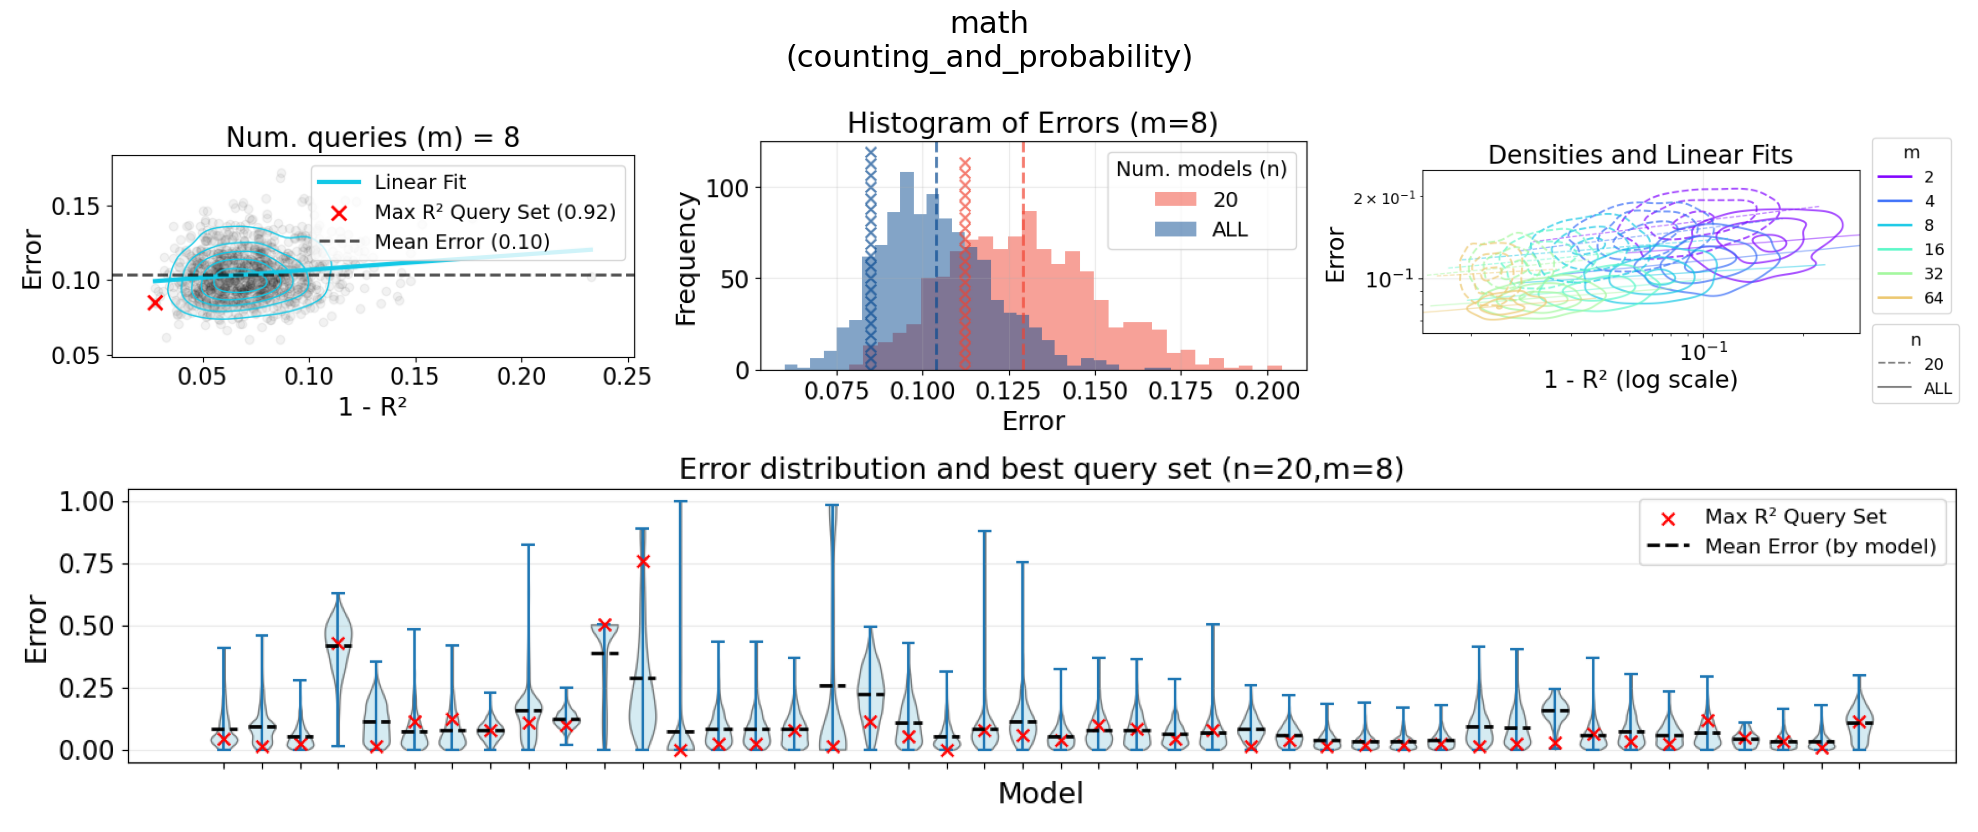

In [217]:
def create_mosaic(image_paths, output_path=None, title=None, display=True):
    """
    Create a mosaic with 3 images on top row and 1 image on bottom row using matplotlib.
    Args:
        image_paths: List of 4 Path objects for the images
        output_path: Path object for the output mosaic image (optional if display=True)
        title: Optional title to display at the top of the mosaic
        display: If True, display the mosaic inline in notebook. If False, only save.
    Returns:
        matplotlib figure object
    """
    import matplotlib.pyplot as plt
    from PIL import Image
    
    # Load images
    images = [Image.open(path) for path in image_paths]
    
    # Create figure with gridspec for custom layout
    fig = plt.figure(figsize=(20, 12))
    
    # Create grid: 2 rows, 3 columns
    # Top row: 3 images side by side
    ax1 = plt.subplot(2, 3, 1)
    ax1.imshow(images[0])
    ax1.axis('off')
    
    ax2 = plt.subplot(2, 3, 2)
    ax2.imshow(images[1])
    ax2.axis('off')
    
    ax3 = plt.subplot(2, 3, 3)
    ax3.imshow(images[2])
    ax3.axis('off')
    
    # Bottom row: 1 image centered across all 3 columns
    ax4 = plt.subplot(2, 1, 2)
    ax4.imshow(images[3])
    ax4.axis('off')
    
    plt.tight_layout()

    plt.subplots_adjust(hspace=-0.55, wspace=0)

    if title:
        fig.suptitle(title, fontsize=fontsize+4, y=0.87)
    
    # Save if output path provided
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=150)
        print(f'Saved mosaic to {output_path}')
    
    # Display if requested
    if display:
        plt.show()
    else:
        plt.close()

    
    
    return fig

create_mosaic(
    [outpath_upper_left, outpath_upper_center, outpath_upper_right, outpath_lower],
    'figures/fig4.pdf',
    title='math\n(counting_and_probability)'
)
print()